# Roots Classical Music Project

## RagaVerse


### Importing libraries, loading metadata spreadsheet 

In [28]:
import os
import numpy as np
import pandas as pd
import librosa
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import ipywidgets as widgets
from IPython.display import display, clear_output
from adjustText import adjust_text
from matplotlib.cm import get_cmap



# Load CSV (column 'Name' = filename, 'Tonic' = musical note like 'A3')

file_path = "RagaVerseDatabase.xlsx"

# Load the Excel file
xlsx = pd.ExcelFile(file_path)

# List to hold DataFrames from all sheets
dfs = []

# Loop through each sheet and add a 'SheetName' column
for sheet_name in xlsx.sheet_names:
    df = pd.read_excel(xlsx, sheet_name=sheet_name)
    df['SheetName'] = sheet_name  # Add sheet name column
    dfs.append(df)

# Concatenate all DataFrames
final_df = pd.concat(dfs, ignore_index=True)

# Optional: View the result
print(final_df.head())



     Raga Tonic                                       YouTube Link  \
0   Yaman    B3  https://www.youtube.com/watch?v=kXJxMbmzqWc&li...   
1  Hameer    B3  https://www.youtube.com/watch?v=fc_FVEkXOqA&li...   
2  Hameer    D3  https://www.youtube.com/watch?v=FtObMbpIJLQ&li...   
3  Hameer    D3  https://www.youtube.com/watch?v=BkQ6eB_c11w&li...   
4    Nand    B3  https://www.youtube.com/watch?v=nUljNh4DEW4&li...   

         Name       Artist name (initials) Start Time (s) End Time (s)  \
0    yaman_MB                  Manali Bose       01:08:00     05:00:00   
1   hameer_MB                  Manali Bose       00:00:00     00:40:00   
2  hameer_MDR                 Mohamad Rafi       00:00:00     00:22:00   
3   hameer_SG  Shreya Goshal and Hariharan       00:19:00     01:00:00   
4     nand_MB                  Manali Bose       00:00:00     02:00:00   

  Processed till source separation (y/n) SheetName  
0                                    NaN    Kalyan  
1                           

### set sampling rate and any other global variables


In [2]:
sr = 16000
sr_nov = 100
note_list = ["S", "r", "R", "g", "G", "m", "M", "P", "d", "D", "n", "N"]
shruti_list = ["S", "r1", "r2", "R1", "R2", "g1", "g2", "G1", "G2", "m1", "m2", "M1", "M2", "P", "d1", "d2", "D1", "D2", "n1", "n2", "N1", "N2"]
full_audio_dir = "tools/downloads"
sep_audio_dir = "tools/separated/vocals"
accom_dir = "tools/separated/no_vocals"
trimmed_dir = "tools/trimmed"

controls = {
	"time_step": 0.01,  # time step between consecutive pitch measurements (in seconds)
	"pitch_floor": 75.0,  # minimum pitch value to detect (in Hz), useful for filtering out low-frequency noise
	"max_number_of_candidates": 15,  # max number of pitch candidates per frame to evaluate
	"very_accurate": False,  # increases accuracy at the cost of performance
	"silence_threshold": 0.03,  # energy threshold to distinguish silence from voiced parts
	"voicing_threshold": 0.35,  # threshold for deciding whether a frame is voiced
	"octave_cost": 0.1,  # cost for selecting a pitch candidate an octave apart from the previous one
	"octave_jump_cost": 0.5 ,  # penalty for sudden jumps between octaves
	"voiced_unvoiced_cost": 0.4,  # cost for transitioning between voiced and unvoiced frames
	"pitch_ceiling": 600  # maximum pitch to detect (in hz)
}

song_list = os.listdir(sep_audio_dir)
name_list = [i[:-11] for i in song_list]

### Loading audio file using librosa, and conversion to pitch contour at window length 10ms, using pyin algorithm

In [3]:
def audio_to_sine_wave(filepath, sr=sr):
    snd = parselmouth.Sound(filepath).resample(sr)
    pitch = snd.to_pitch_ac(
		time_step=controls["time_step"],
		pitch_floor=controls["pitch_floor"],
		max_number_of_candidates=controls["max_number_of_candidates"],
		very_accurate=controls["very_accurate"],
		silence_threshold=controls["silence_threshold"],
		voicing_threshold=controls["voicing_threshold"],
		octave_cost=controls["octave_cost"],
		octave_jump_cost=controls["octave_jump_cost"],
		voiced_unvoiced_cost=controls["voicing_threshold"],
		pitch_ceiling=controls["pitch_ceiling"]
		) 
    # time_step = analysis hop size

    # Extract pitch values
    f0 = pitch.selected_array['frequency']  # In Hz
    times = pitch.xs()
    times = np.array([i/100 for i in range(0, len(f0))])

    voiced_regions = np.sign(f0)
    # unvoiced_regions = np.logical_not(voiced_regions).astype(int)
    
    return f0, times, voiced_regions


### Hertz to cents conversion using tonic of the audio file

In [4]:
def hz_to_cents(f0, name):
    tonic_str = final_df.loc[final_df['Name'] == name, 'Tonic'].values
    print(name, tonic_str)
    if tonic_str.size > 0:
        tonic = librosa.note_to_hz(tonic_str[0])
    else:
        tonic = librosa.note_to_hz('B3')  # Default tonic if not found
    if tonic is None:
        # Use median non-zero value as tonic estimate
        tonic = np.median(f0[f0 > 0])
    cents = 1200 * np.log2(f0 / tonic)
    return cents, tonic


### Plotting function for the pitch contour (x: time, y: cents)

In [5]:
def plot_pitch_contour(cents, sr, hop_length=sr/100):
    time = np.arange(len(cents)) * hop_length / sr
    plt.figure(figsize=(10, 3))
    plt.plot(time, cents, label='Pitch contour (cents)')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (cents)')
    plt.title('Pitch Contour')
    plt.grid(True)
    plt.show()


### Remove transition regions

In [6]:
def remove_transition_regions_scrollable(cents, times, filename, sd_threshold=3, hop_size=1, window_size=3):
    cents = np.array(cents)
    times = np.array(times)
    num_windows = (len(times) - window_size) // hop_size + 1
    stable_regions = []

    for i in range(num_windows):
        start = i * hop_size
        end = start + window_size
        segment = cents[start:end]
        t_segment = times[start:end]
        voiced_indices = segment > -np.inf
        segment_voiced = segment[voiced_indices]
        t_segment_voiced = t_segment[voiced_indices]
        if len(segment_voiced) < 2:
            continue
        sd_f0 = np.std(segment_voiced)
        if sd_f0 < sd_threshold:
            stable_regions.append((t_segment_voiced[0], t_segment_voiced[-1]))

    # Group contiguous stable regions
    contiguous_regions = []
    current_region = None
    for start_t, end_t in stable_regions:
        if current_region is None:
            current_region = [start_t, end_t]
        else:
            if start_t - current_region[1] <= hop_size / sr_nov:
                current_region[1] = end_t
            else:
                contiguous_regions.append(tuple(current_region))
                current_region = [start_t, end_t]
    if current_region is not None:
        contiguous_regions.append(tuple(current_region))

    mask = np.zeros_like(times, dtype=bool)
    for start, end in contiguous_regions:
        mask |= (times >= start) & (times <= end)

    cents_filtered = cents[mask]
    # times_filtered = times[mask]
    return cents_filtered, contiguous_regions


## Pre-processing ends

### Compute pitch class distributions

### Soft binning using guassian weighting

instead of assigning a single bin, for every pitch point in the contour, every pitch value is assigned a 12 dim weight vector, indicating weights towards all the bins, this captures the fluid nature of the pith contour in HCM

In [7]:
def compute_pitch_class_distribution_gaussian(cents, bins=12, sigma=25.0):
    """
    Computes pitch class distribution using Gaussian weighting around bin centers.

    Args:
        cents (np.ndarray): Pitch contour in cents.
        bins (int): Number of pitch class bins per octave (default: 12).
        sigma (float): Standard deviation of Gaussian kernel in cents.

    Returns:
        np.ndarray: Normalized pitch class distribution (length = bins).
    """
    # Clean data
    cents = cents[~np.isnan(cents) & ~np.isinf(cents)]
    if len(cents) == 0:
        return np.zeros(bins)

    # Fold pitches into a single octave (0–1200 cents)
    wrapped = np.mod(cents, 1200)

    # Bin centers
    bin_centers = np.linspace(0, 1200, bins, endpoint=False)

    # Initialize distribution
    hist = np.zeros(bins)

    for pitch in wrapped:
        # Compute wrapped distance to bin centers
        diffs = np.abs(pitch - bin_centers)
        diffs = np.minimum(diffs, 1200 - diffs)  # handle circular wrap-around

        # Gaussian weights
        weights = np.exp(-(diffs**2) / (2 * sigma**2)) 
        weights /= np.sum(weights)  # normalize to sum to 1

        hist += weights

    # Normalize histogram
    hist /= np.sum(hist)

    return hist


Compute more features!!

In [8]:
# Compute additional features
# add your feature (should be a number or a set of numbers at the end of processing)


dimensionality reduction to n components (n=2) using pca or t-SNE and plotting

In [25]:
def plot_2d_embedding(features, labels=None, method='pca', title='2D Projection', show_text=True):
    emb = (PCA(n_components=2) if method == 'pca' else TSNE(n_components=2, perplexity=5, init='pca')).fit_transform(StandardScaler().fit_transform(features))
    colors = [get_cmap('tab20' if len(emb) <= 20 else 'hsv')(i % 20) for i in range(len(emb))]
    plt.figure(figsize=(7, 6))
    plt.scatter(emb[:, 0], emb[:, 1], color=colors, s=70, alpha=0.9)

    if show_text and labels is not None:
        texts = [plt.text(x, y, str(l), fontsize=8) for (x, y), l in zip(emb, labels)]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
    plt.title(f'{method.upper()} - {title}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()


In [10]:
def plot_pitch_scrollable_with_slider(times, cents, filename, stable_regions, window=5.0):
    duration = times[-1]
    slider = widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=max(0.1, duration - window),
        step=0.1,
        description='Time:',
        continuous_update=False,
        layout=widgets.Layout(width='60%')
    )
    out = widgets.Output()

    def update_plot(change):
        with out:
            clear_output(wait=True)
            start = change['new']
            end = start + window
            fig, ax = plt.subplots(figsize=(12, 3))
            mask = (times >= start) & (times <= end)
            ax.scatter(times[mask], cents[mask], color="black", s=1)
            for s, e in stable_regions:
                if s > end or e < start:
                    continue
                ax.axvspan(max(s, start), min(e, end), color='red', alpha=0.2)
            ax.set_xlim([start, end])
            ax.set_ylim([-1000, 1000])
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Pitch (cents)")
            ax.set_title(filename + " - Scrollable Pitch Contour")
            plt.grid(True)
            plt.show()

    slider.observe(update_plot, names='value')
    display(slider, out)
    # Trigger once to show initial plot
    update_plot({'new': slider.value})


Add your feature

In [11]:
features = []
labels = []

In [12]:
for filename in song_list:
    if filename.endswith(".wav"):
        path = os.path.join(sep_audio_dir, filename)
        f0, times, voiced_regions = audio_to_sine_wave(path)
        cents, tonic = hz_to_cents(f0, name=filename.split('.')[0][:-7])  # Use filename as name
        # Remove transition regions
        cents_filtered, contiguous_regions = remove_transition_regions_scrollable(cents, times, filename, sd_threshold=3, hop_size=1, window_size=3)
        plot_pitch_scrollable_with_slider(times, cents, filename, contiguous_regions)
        # Compute pitch class distribution

        hist = compute_pitch_class_distribution_gaussian(cents, bins=12, sigma=25.0)


        # print(hist, tonic )
        features.append(hist)
        #append your new feature in features, or try out the features ablatively.
        labels.append(filename.split('_')[0])  # or use raga name


jhoothenainabole_AB ['C#3']


/var/folders/lc/598jm6692t38zzq_tcm91n240000gn/T/ipykernel_6212/1461578605.py:11: RuntimeWarning: divide by zero encountered in log2
  cents = 1200 * np.log2(f0 / tonic)


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=94.96)

Output()

ahirbhairav_MB ['B3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=59.95)

Output()

multani_MB ['A#3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=109.96)

Output()

bilaskhanitodi_MB ['B3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=174.96)

Output()

hamsadhwani_MB ['A#3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=69.95)

Output()

lalit_MB ['A#3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=114.96)

Output()

todi_MB ['B3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=134.96)

Output()

bhairavi_MB ['A#3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=174.96)

Output()

bageshree_MB ['B3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=294.95)

Output()

nirmohiya_BB ['E3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=229.96)

Output()

rang_AVC ['D3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=104.96)

Output()

marwa_MB ['A#3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=346.96)

Output()

bhimpalasi_MB ['B3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=369.96)

Output()

jabdeepjale_Y ['E3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=114.96)

Output()

yaman_MB ['B3']


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=227.96)

Output()

### Plot the PCD histograms

[0.17869304 0.14024353 0.10572623 0.19099115 0.05835361 0.06966679
 0.01828601 0.03371951 0.07121779 0.04272046 0.03763891 0.05274297]


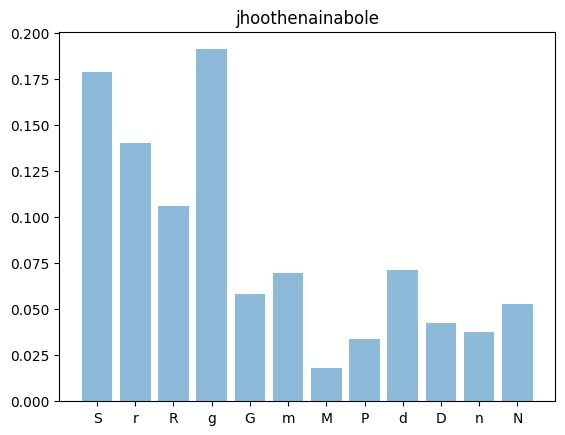

[0.03047518 0.26118378 0.0316689  0.02463437 0.17833167 0.16489675
 0.01494685 0.1315054  0.0153147  0.07041251 0.06951155 0.00711833]


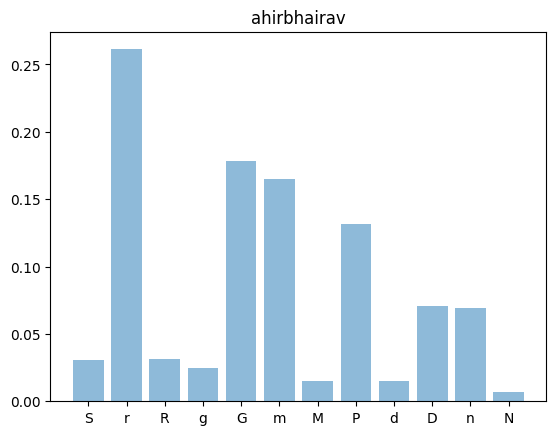

[0.20614069 0.01482901 0.00657    0.10429709 0.0338068  0.0305369
 0.25502179 0.18012133 0.01598284 0.00615999 0.00752012 0.13901344]


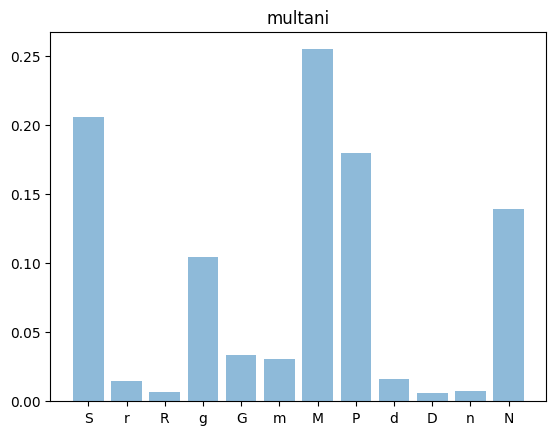

[0.20841173 0.17065898 0.05586951 0.08972972 0.02330402 0.08332249
 0.0219573  0.08534072 0.12614903 0.03817982 0.0632339  0.03384277]


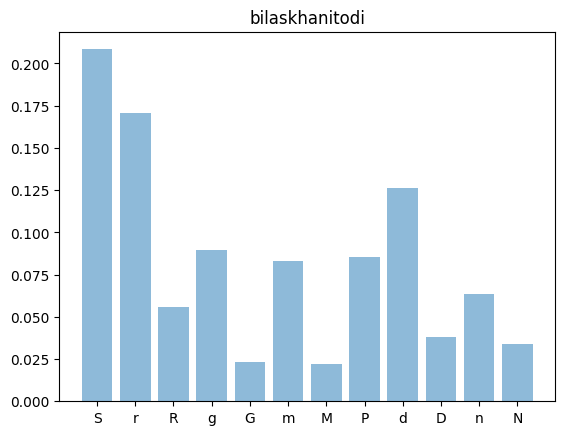

[0.24390054 0.01768444 0.27263958 0.02277401 0.12176404 0.02402942
 0.02144858 0.13980891 0.02086506 0.01697211 0.02403159 0.07408171]


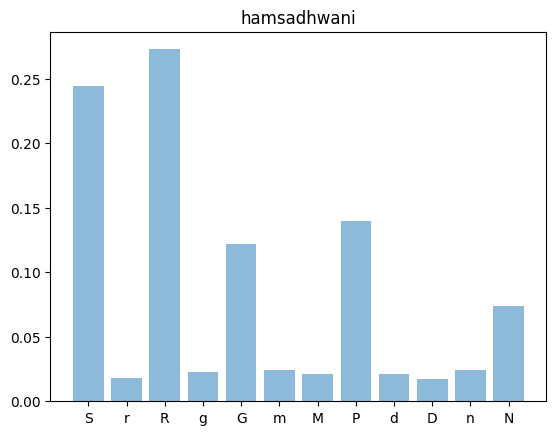

[0.16832784 0.067069   0.02135192 0.01917082 0.23768148 0.16538401
 0.12680366 0.03146289 0.11342182 0.00847719 0.00587095 0.03497842]


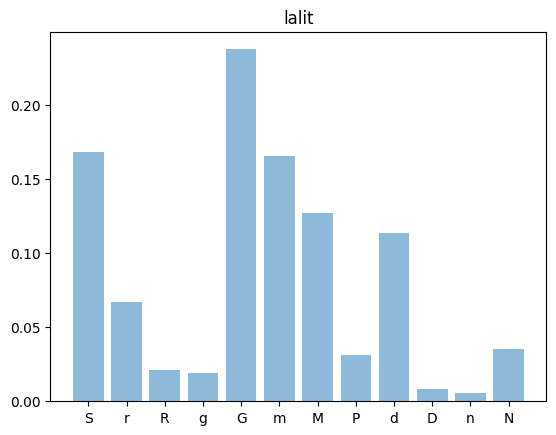

[0.23581207 0.08928083 0.01562174 0.07664521 0.0082573  0.00567309
 0.03574919 0.13073564 0.28143442 0.02205662 0.01858804 0.08014586]


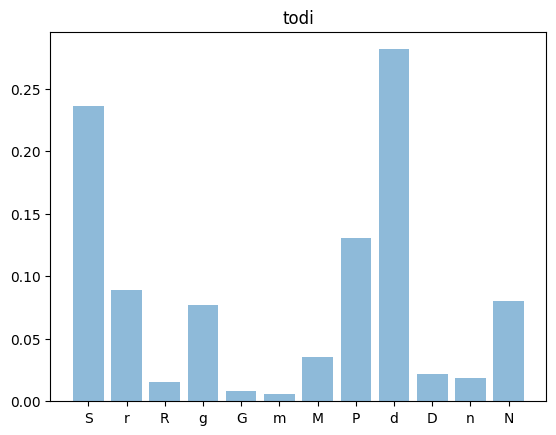

[0.25673504 0.05301648 0.02614589 0.13347617 0.01966431 0.07037327
 0.02381714 0.15416024 0.16956055 0.01567281 0.04900621 0.0283719 ]


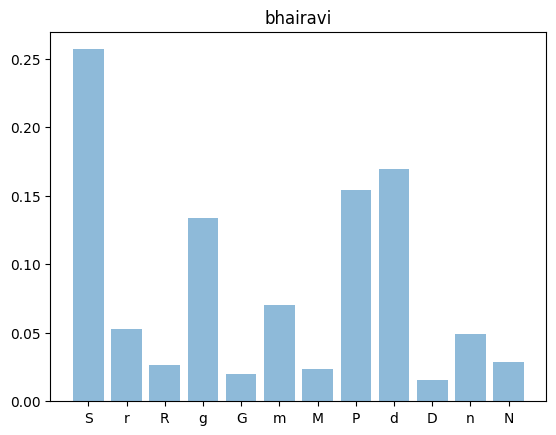

[0.2077033  0.01467642 0.0920187  0.10826762 0.03802409 0.0941667
 0.01167337 0.02299648 0.02311802 0.17896125 0.16221428 0.04617975]


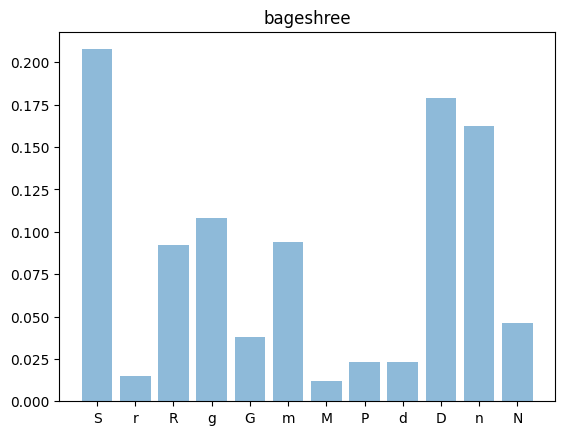

[0.14391315 0.01897525 0.09764707 0.02483856 0.12453876 0.02872666
 0.13819275 0.12569781 0.01770084 0.07413271 0.0312419  0.17439453]


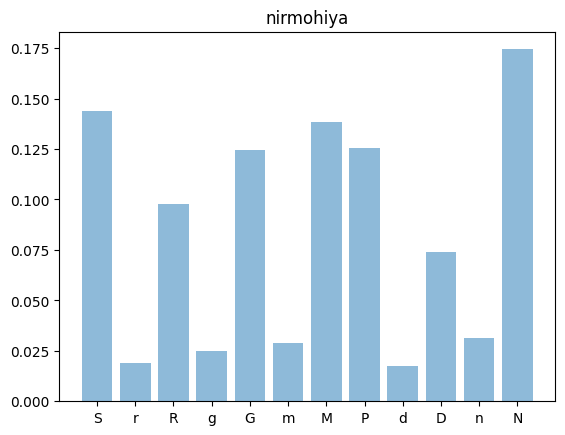

[0.15810185 0.03734252 0.10874639 0.09496467 0.03821195 0.09603074
 0.01863406 0.02068833 0.02794602 0.19084399 0.17446808 0.0340214 ]


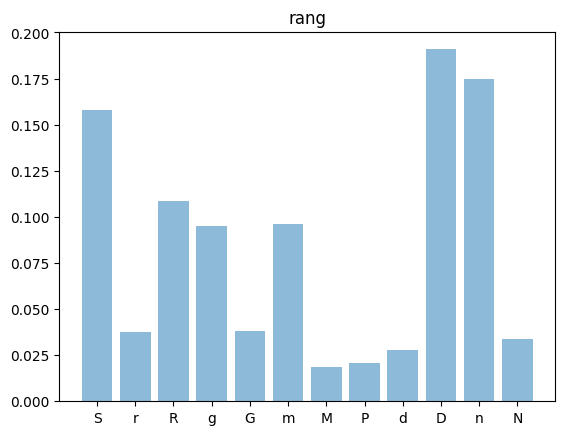

[0.14319384 0.26286113 0.01561901 0.01673793 0.06393264 0.01878615
 0.08725729 0.02515296 0.01790265 0.18678458 0.03698629 0.12478553]


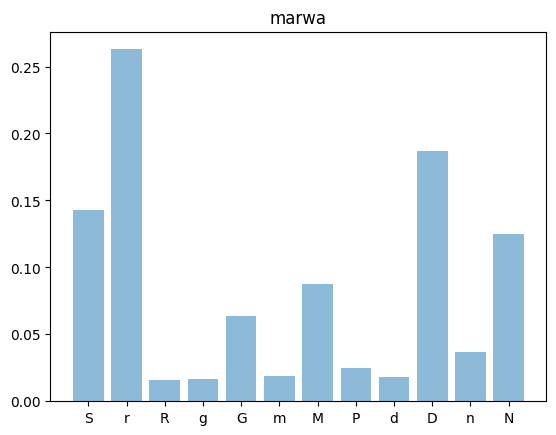

[0.15834094 0.02962946 0.10170399 0.09247162 0.04114785 0.11314923
 0.03747014 0.12970299 0.0368019  0.06261755 0.12623    0.07073432]


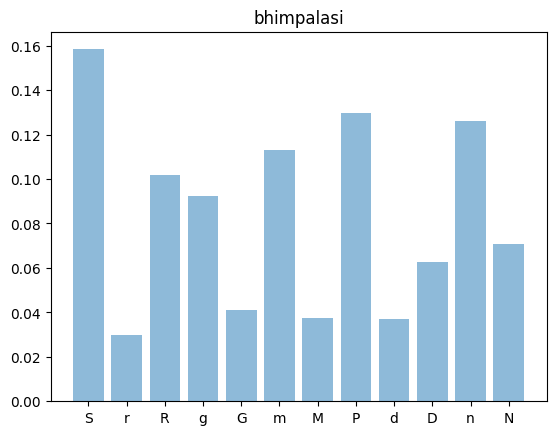

[0.11599964 0.0719983  0.08617752 0.02784867 0.05315264 0.08598001
 0.14698691 0.13598053 0.02647088 0.04288975 0.06455276 0.1419624 ]


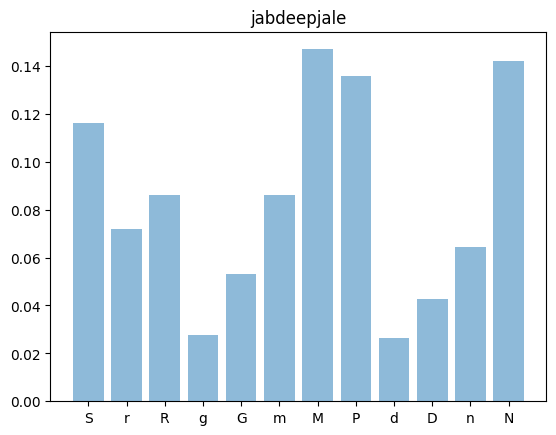

[0.16518623 0.01352706 0.09239806 0.04166293 0.1678825  0.04031432
 0.11709953 0.10502243 0.01095813 0.0342945  0.03467461 0.1769797 ]


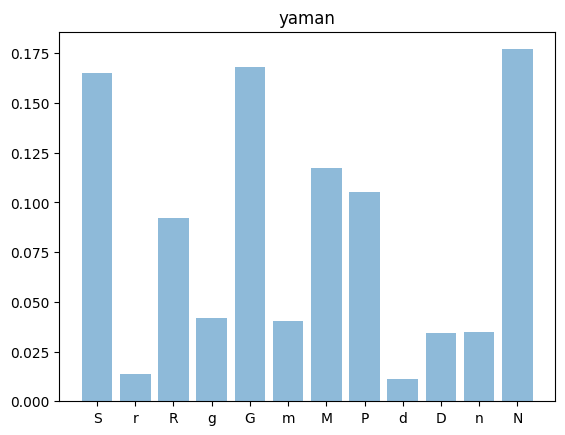

In [13]:
for hist, label in zip(features, labels):
    print(hist)
    plt.bar(x=note_list, height=hist, label=label, alpha=0.5)
    plt.title(label)
    plt.show()

### Plot the 2d embeddings obtained upon pca

/var/folders/lc/598jm6692t38zzq_tcm91n240000gn/T/ipykernel_6212/3903119069.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [get_cmap('tab20' if len(emb) <= 20 else 'hsv')(i % 20) for i in range(len(emb))]


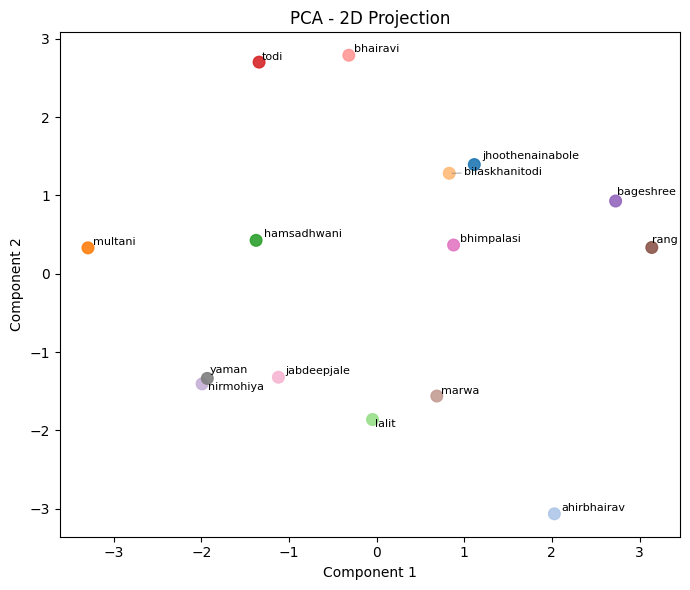

In [29]:
plot_2d_embedding(features, labels, method='pca')

### Plotting for single audio file

In [ ]:
# filename = "bageshree_MB_vocals.wav"
# path = os.path.join(sep_audio_dir, filename)
# f0, times, voiced_regions = audio_to_sine_wave(path)
# cents, tonic = hz_to_cents(f0, name=filename.split('.')[0][:-7])  # Use filename as name
# # Remove transition regions
# cents_filtered, contiguous_regions = remove_transition_regions_scrollable(cents, times, filename, sd_threshold=4, hop_size=2, window_size=5)
# # Compute pitch class distribution

# # hist = compute_pitch_class_distribution(cents, bins=12, threshold=25)
# hist = compute_pitch_class_distribution_gaussian(cents, bins=12, sigma=25.0)

# # Also return stable_regions from that function (modify accordingly)
# plot_pitch_scrollable_with_slider(times, cents, filename, contiguous_regions)


bageshree_MB ['B3']


/var/folders/lc/598jm6692t38zzq_tcm91n240000gn/T/ipykernel_6212/1461578605.py:11: RuntimeWarning: divide by zero encountered in log2
  cents = 1200 * np.log2(f0 / tonic)


FloatSlider(value=0.0, continuous_update=False, description='Time:', layout=Layout(width='60%'), max=294.95)

Output()